In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

from wordcloud import WordCloud ,STOPWORDS

from collections import Counter
import re
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')

sns.set(style="white", context="talk")

ModuleNotFoundError: No module named 'nltk'

In [5]:
df_train = pd.read_csv("/home/burtenshaw/data/toxic/train.csv", index_col=0)
COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Adding 'none' columns if there is no '1' in COLUMNS
df_train['none'] = (df_train[COLUMNS].max(axis=1) == 0).astype(int)
COLUMNS.append('none')
CATEGORIES = COLUMNS.copy()

print(df_train.shape)
print(df_train.columns.values)

(143613, 9)
['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate' 'none']


# Simple Distribution

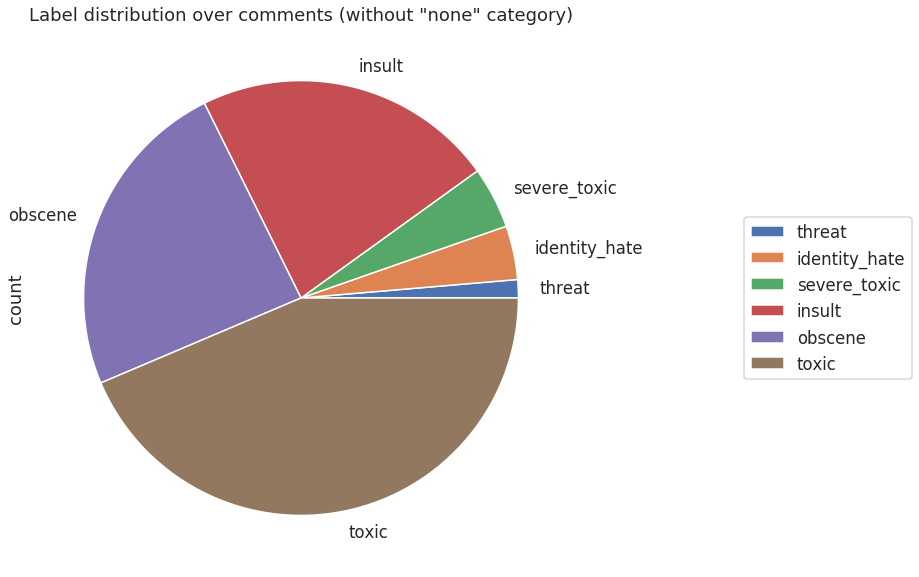

In [6]:
df_distribution = df_train[COLUMNS].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.drop('none').plot.pie(y='count',
                                      title='Label distribution over comments (without "none" category)',
                                      figsize=(20, 10))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [7]:
df_distribution.sort_values('count', ascending=False)

,count
none,129027
toxic,13751
obscene,7585
insult,7060
severe_toxic,1445
identity_hate,1261
threat,428


The three major labels are :
1. toxic
2. obscene
3. insult

Let's take a look at the number of comment for each label combination.

Here we are looking for combinations that are frequent. Which would indicate a correlation between categories

In [8]:
df_comb = df_train.groupby(COLUMNS)\
                    .size()\
                    .sort_values(ascending=False)\
                    .reset_index()\
                    .rename(columns={0: 'count'})
df_comb.head(n=10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,count
0,0,0,0,0,0,0,1,129027
1,1,0,0,0,0,0,0,5116
2,1,0,1,0,1,0,0,3400
3,1,0,1,0,0,0,0,1572
4,1,0,0,0,1,0,0,1087
5,1,1,1,0,1,0,0,898
6,1,0,1,0,1,1,0,556
7,0,0,1,0,0,0,0,291
8,0,0,0,0,1,0,0,270
9,1,1,1,0,1,1,0,238


We can see several things : 
1. As expected, the 'none' label is clearly ahead with 86061 comments
2. 'toxic', which is the first 'real' label, is coming in all combination from rank 1 to 6
3. In this 6 rows, 'obscene' comes 4 times   
4. The number of comments for each combination drops exponentially

Let's check the correlation matrix :


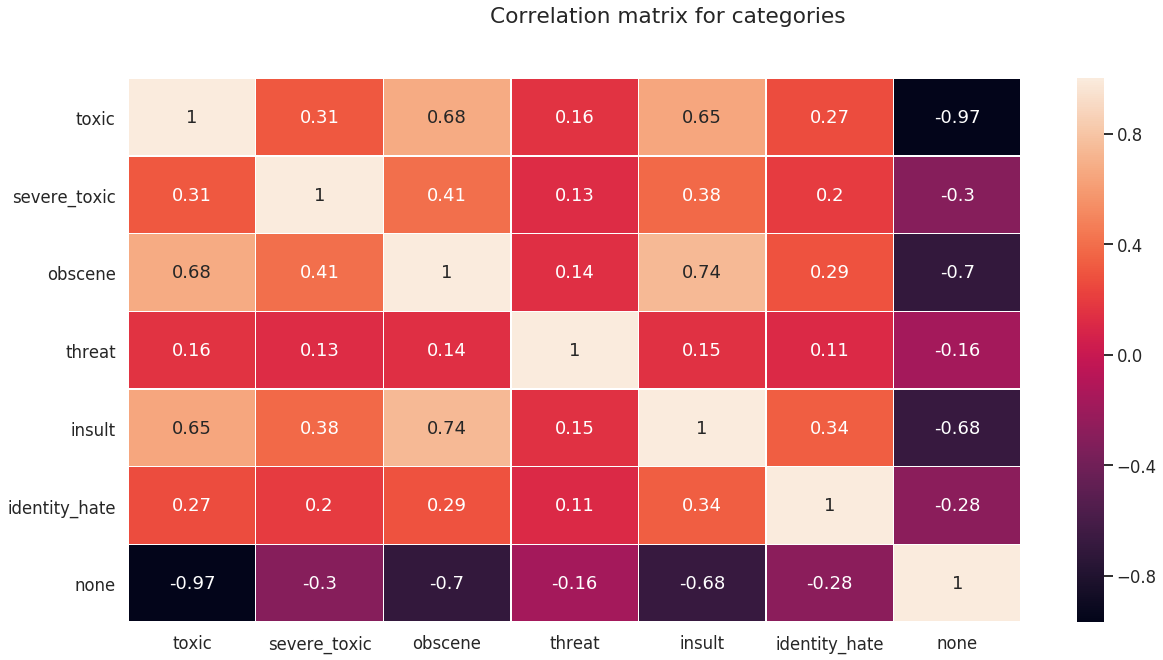

In [9]:
f, ax = plt.subplots(figsize=(20, 10))
f.suptitle('Correlation matrix for categories')
sns.heatmap(df_train[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)


The correlation matrix shows interesting things : 

1. 'toxic' is clearly correlated with 'obscene' and 'insult' (0.68 and 0.65)
2. 'toxic' and 'severe_toxic' are only got a 0.31 correlation factor
3. 'insult' and 'obscene' have a correlation factor of 0.74


From my point of view, there are several combinations that are worth digging into :

1. 'toxic' <-> 'severe_toxic'. The semantic of these two categories seems to show some kind of graduation between them
2. 'toxic' <-> 'insult' and 'toxic' <-> 'obscene'
3. 'insult' <-> 'obscene'

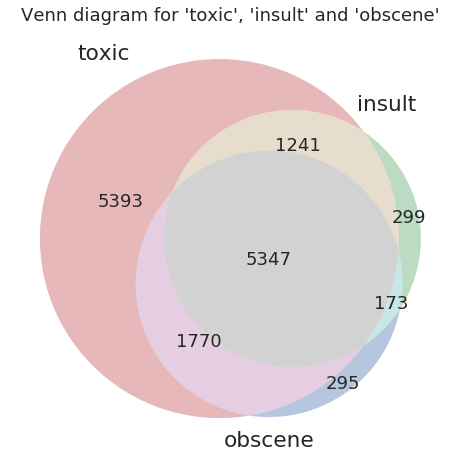

In [16]:

t = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 0) & (df_train['obscene'] == 0)].shape[0]
i = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 1) & (df_train['obscene'] == 0)].shape[0]
o = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 0) & (df_train['obscene'] == 1)].shape[0]

t_i = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 1) & (df_train['obscene'] == 0)].shape[0]
t_o = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 0) & (df_train['obscene'] == 1)].shape[0]
i_o = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 1) & (df_train['obscene'] == 1)].shape[0]

t_i_o = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 1) & (df_train['obscene'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o), 
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()


This venn diagram demonstrates the correlations found in the previous visualization. 

1. There is only a small part of 'insult' and 'obscene' that are not also labelled 'toxic'.
2. 3610 comments are labelled with all 3 categories.

**Note: ** The library used for the Venn diagram does not have a venn4 object, that's why I couldn't display 'severe_toxic' with them.

Let's take a look at the Venn diagram between 'toxic' and 'severe_toxic'.

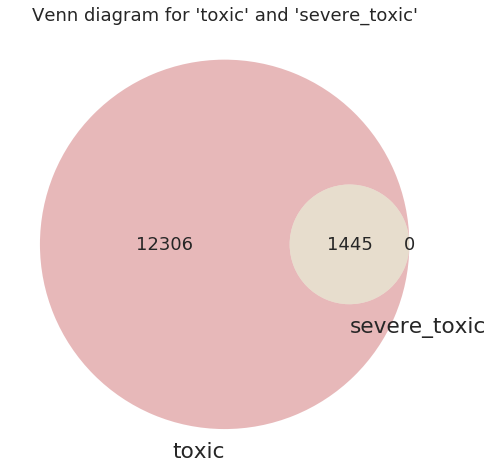

In [10]:

t = df_train[(df_train['toxic'] == 1) & (df_train['severe_toxic'] == 0)].shape[0]
s = df_train[(df_train['toxic'] == 0) & (df_train['severe_toxic'] == 1)].shape[0]

t_s = df_train[(df_train['toxic'] == 1) & (df_train['severe_toxic'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic' and 'severe_toxic'")
venn2(subsets = (t, s, t_s), 
      set_labels=('toxic', 'severe_toxic'))
plt.show()


1. The 'severe_toxic' category is completely contained in 'toxic' which goes in favor of the semantic link between the two category names. 
2. The 0.31 correlation factor is explained by the fact that 'severe_toxic' representes a small percentage (11.67%) of 'toxic'. 

Before diving into words, let's analyze the comment structure :

1. Total length
    * It could indicate the writer implication (either in a good way or 'bad' one)
2. Total number of carriage returns
    * It could indicate some kind of structure in the comment

In [11]:
df_train['total_length'] = df_train['comment_text'].str.len()
df_train['new_line'] = df_train['comment_text'].str.count('\n'* 1)
df_train['new_small_space'] = df_train['comment_text'].str.count('\n'* 2)
df_train['new_medium_space'] = df_train['comment_text'].str.count('\n'* 3)
df_train['new_big_space'] = df_train['comment_text'].str.count('\n'* 4)

df_train['new_big_space'] = df_train['comment_text'].str.count('\n'* 4)
df_train['uppercase_words'] = df_train['comment_text'].apply(lambda l: sum(map(str.isupper, list(l))))
df_train['question_mark'] = df_train['comment_text'].str.count('\?')
df_train['exclamation_mark'] = df_train['comment_text'].str.count('!')

FEATURES = ['total_length', 
            'new_line', 
            'new_small_space', 
            'new_medium_space', 
            'new_big_space', 
            'uppercase_words',
            'question_mark',
            'exclamation_mark']
COLUMNS += FEATURES

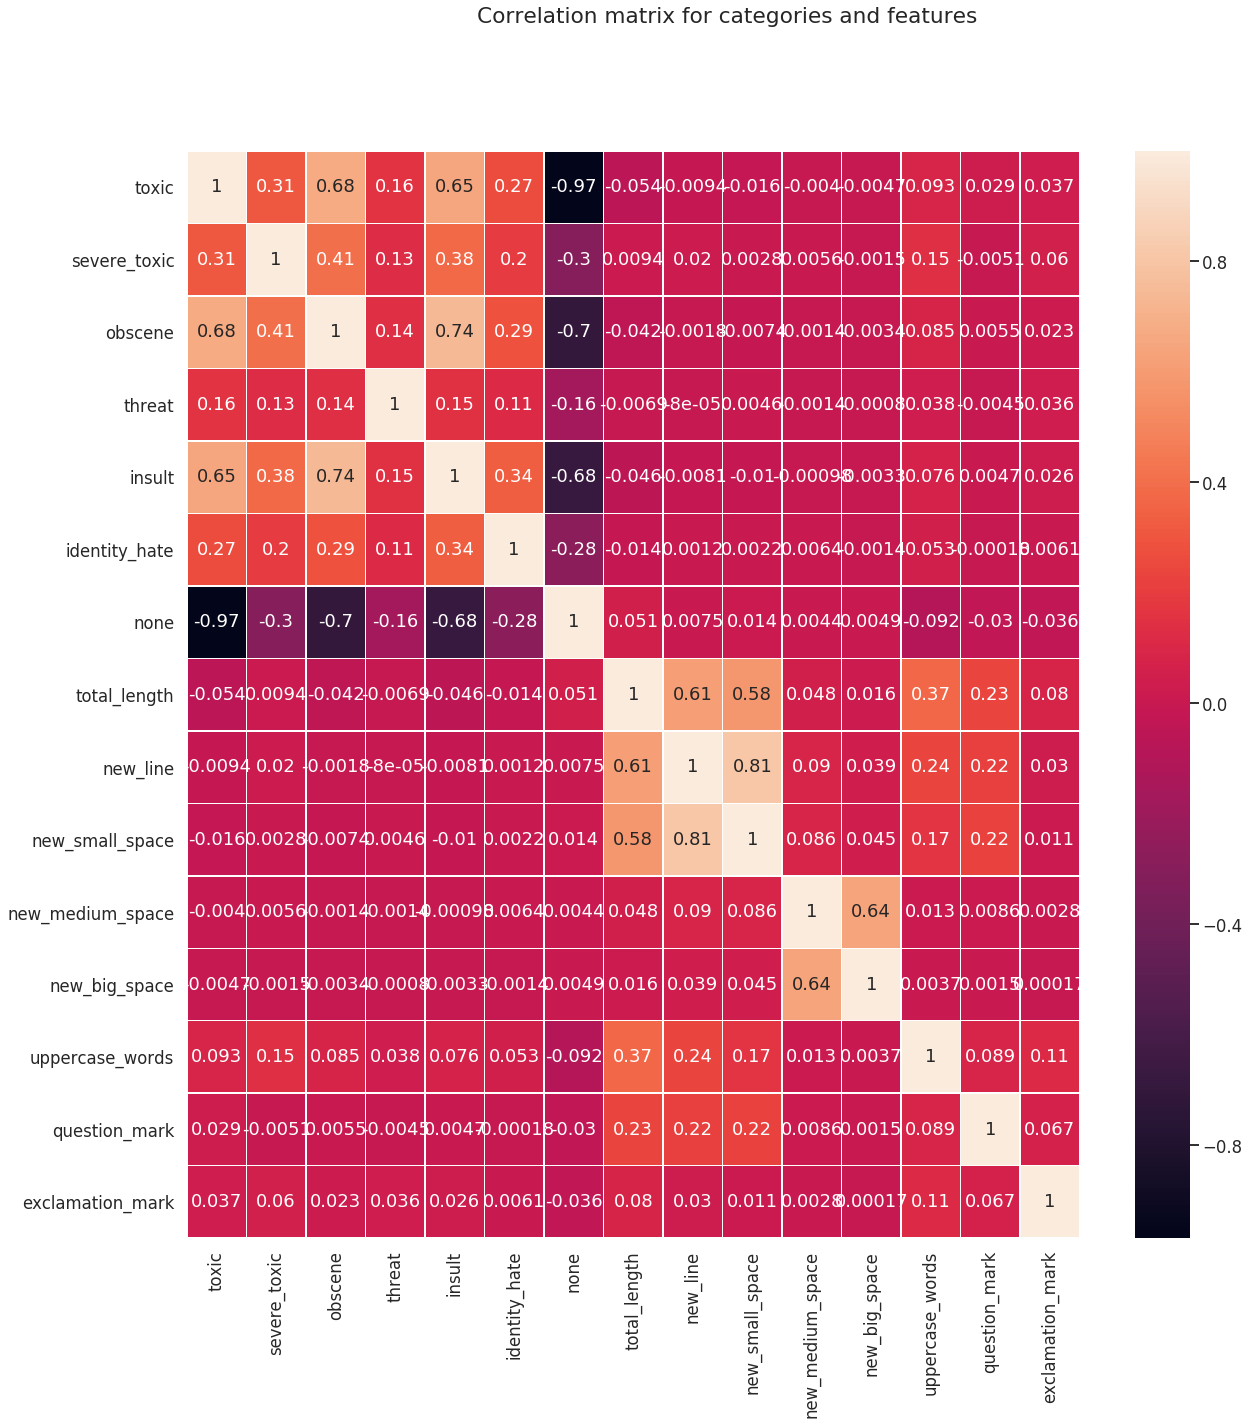

In [12]:
f, ax = plt.subplots(figsize=(20, 20))
f.suptitle('Correlation matrix for categories and features')
sns.heatmap(df_train[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)


**Note: ** small, medium and big space features are inclusive, meaning that all 'big_space' are medium and small ones (same for medium_space)

1. The new correlation matrix with the added features does not show any strong correlations. 
2. One thing worth noting is that 'uppercase_words' (which could be assimilated to 'yelling') is slightly more correlated.
3. 'uppercase_words' are correlated with 'exclamation_mark' up to 0.13 which could mean that people express the urge to add as many '!' as possible when they are 'yelling' ;)


There is nothing else that comes in mind that I could explore. Please feel free to suggest any idea in comments below.

# Word analysis




In [20]:
word_counter = {}


def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop)])

for categ in CATEGORIES:
    d = Counter()
    df_train[df_train[categ] == 1]['comment_text'].apply(lambda t: d.update(clean_text(t).split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

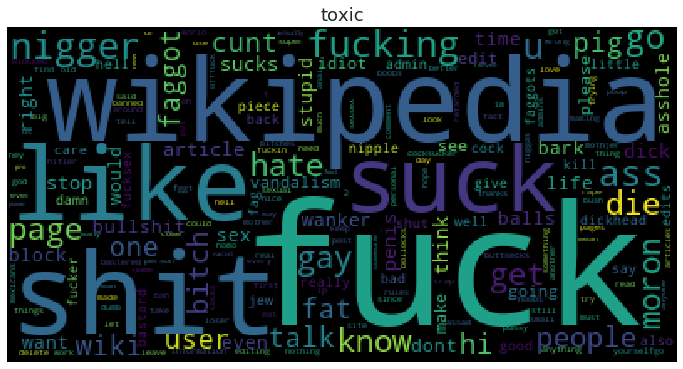

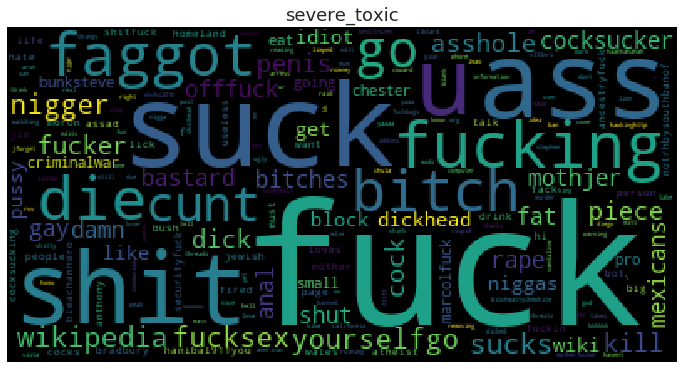

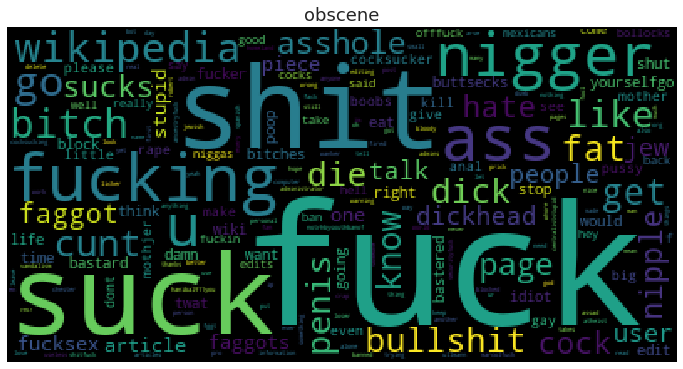

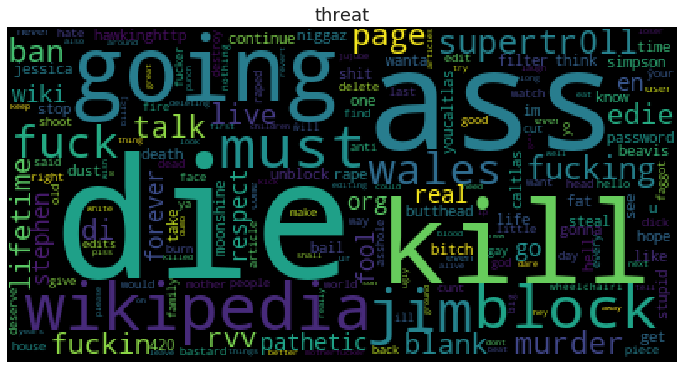

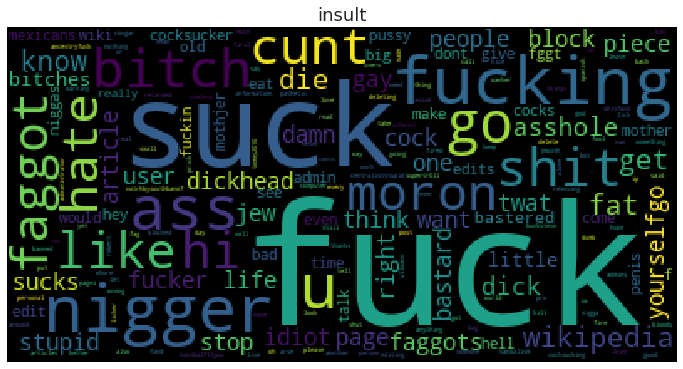

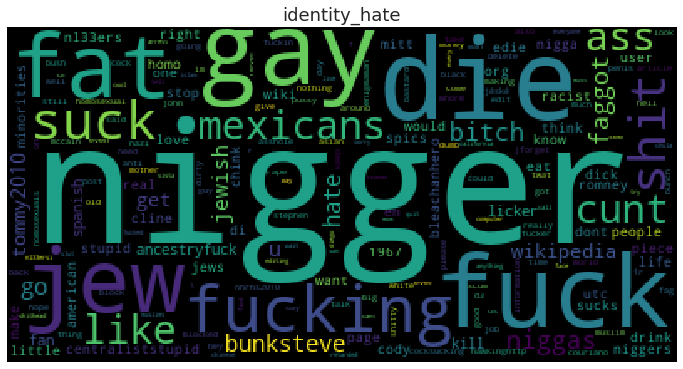

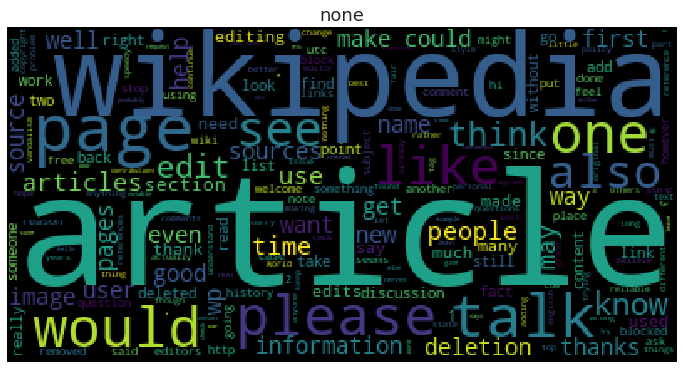

In [21]:
for w in word_counter:
    wc = word_counter[w]

    wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(12, 8))
    plt.title(w)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()


The vocabulary used in all categories is quite similar (expect for 'none' of course). Frequencies are varying a bit across (for example 'fuck' and 'suck'.

# Overview of Bias in Dataset

In [2]:
train = pd.read_csv('/home/burtenshaw/data/toxic/bias/train.csv')

NameError: name 'pd' is not defined

In [4]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [6]:
train.isnull().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

## Lexical Features compared to Target Labels

FE: Some features might have relations with Toxicity, like capitals letters in the text, punctuations in the texts. Add the new features into the training set.

In [10]:
train['total_length'] = train['comment_text'].apply(len)
train['capitals'] = train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
train['num_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))
train['num_question_marks'] = train['comment_text'].apply(lambda comment: comment.count('?'))
train['num_punctuation'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train['num_symbols'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
train['num_words'] = train['comment_text'].apply(lambda comment: len(comment.split()))
train['num_unique_words'] = train['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))
train['words_vs_unique'] = train['num_unique_words'] / train['num_words']
train['num_smilies'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

features = ('total_length', 'capitals', 'caps_vs_length', 'num_exclamation_marks','num_question_marks', 'num_punctuation', 'num_words', 'num_unique_words','words_vs_unique', 'num_smilies', 'num_symbols')
columns = ('target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit','identity_annotator_count', 'toxicity_annotator_count')
rows = [{c:train[f].corr(train[c]) for c in columns} for f in features]
train_correlations = pd.DataFrame(rows, index=features)

train_correlations

,target,severe_toxicity,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
total_length,0.006444,0.007962,0.009823,0.053430,0.009085,-0.013198,-0.084710,0.002572,-0.019940,0.060639,0.017617,0.019882,0.020840,-0.030894
capitals,0.026120,0.025127,0.027995,0.050489,0.026358,0.000721,-0.039221,0.009687,-0.005448,0.018707,0.003928,0.014144,0.012405,-0.009082
caps_vs_length,-0.005344,0.010594,0.017088,-0.008477,-0.006029,0.000822,0.021263,-0.000603,0.002848,-0.038470,-0.021716,-0.003575,-0.005510,0.015381
num_exclamation_marks,0.055152,0.035388,0.056108,0.017085,0.052533,0.021267,0.007073,0.002225,0.005158,-0.007866,-0.009384,0.019437,0.000869,0.024115
num_question_marks,0.019308,0.011662,0.019233,0.028554,0.014366,-0.000430,-0.009290,0.001263,0.002023,-0.002731,-0.002180,0.015987,0.006305,-0.003307
num_punctuation,0.016974,0.013266,0.017701,0.042990,0.018911,-0.006479,-0.057187,0.001959,-0.016511,0.029581,0.001415,0.018985,0.018050,-0.021231
num_words,0.009579,0.009696,0.014536,0.050527,0.011975,-0.009893,-0.084398,0.002714,-0.019412,0.059481,0.016121,0.021525,0.020595,-0.029856
num_unique_words,0.016702,0.011900,0.017918,0.053659,0.019494,-0.008946,-0.085764,0.003490,-0.018110,0.063874,0.019634,0.022816,0.020787,-0.029814
words_vs_unique,0.001172,-0.005329,-0.003007,-0.048941,0.001135,0.009367,0.079045,-0.004150,0.016223,-0.060162,-0.020712,-0.015748,-0.019749,0.027853
num_smilies,-0.010040,-0.003877,-0.001024,-0.008337,-0.009401,-0.003190,0.010109,-0.002777,-0.002133,-0.016607,-0.010936,-0.000414,-0.000576,-0.003030


Correlations between new features and targets in heatmap:

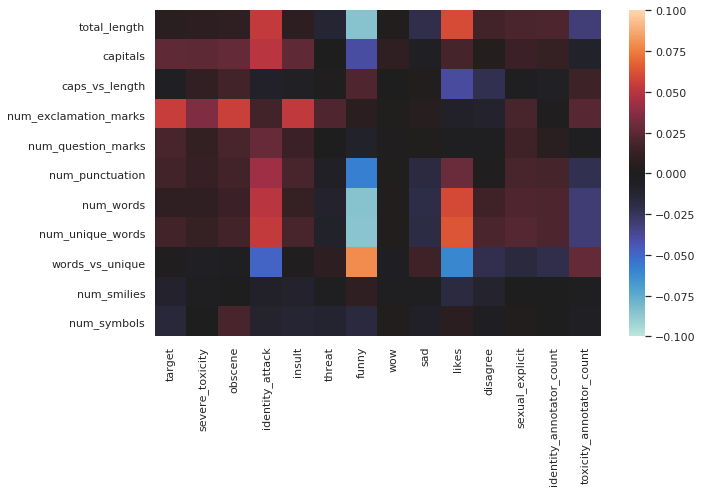

In [11]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1)
ax = sns.heatmap(train_correlations, vmin=-0.1, vmax=0.1, center=0.0)

## Message Author Demographic and Target Labels

Percent of toxic comments related to different identities, using target and popolation amount of each identity as weights:

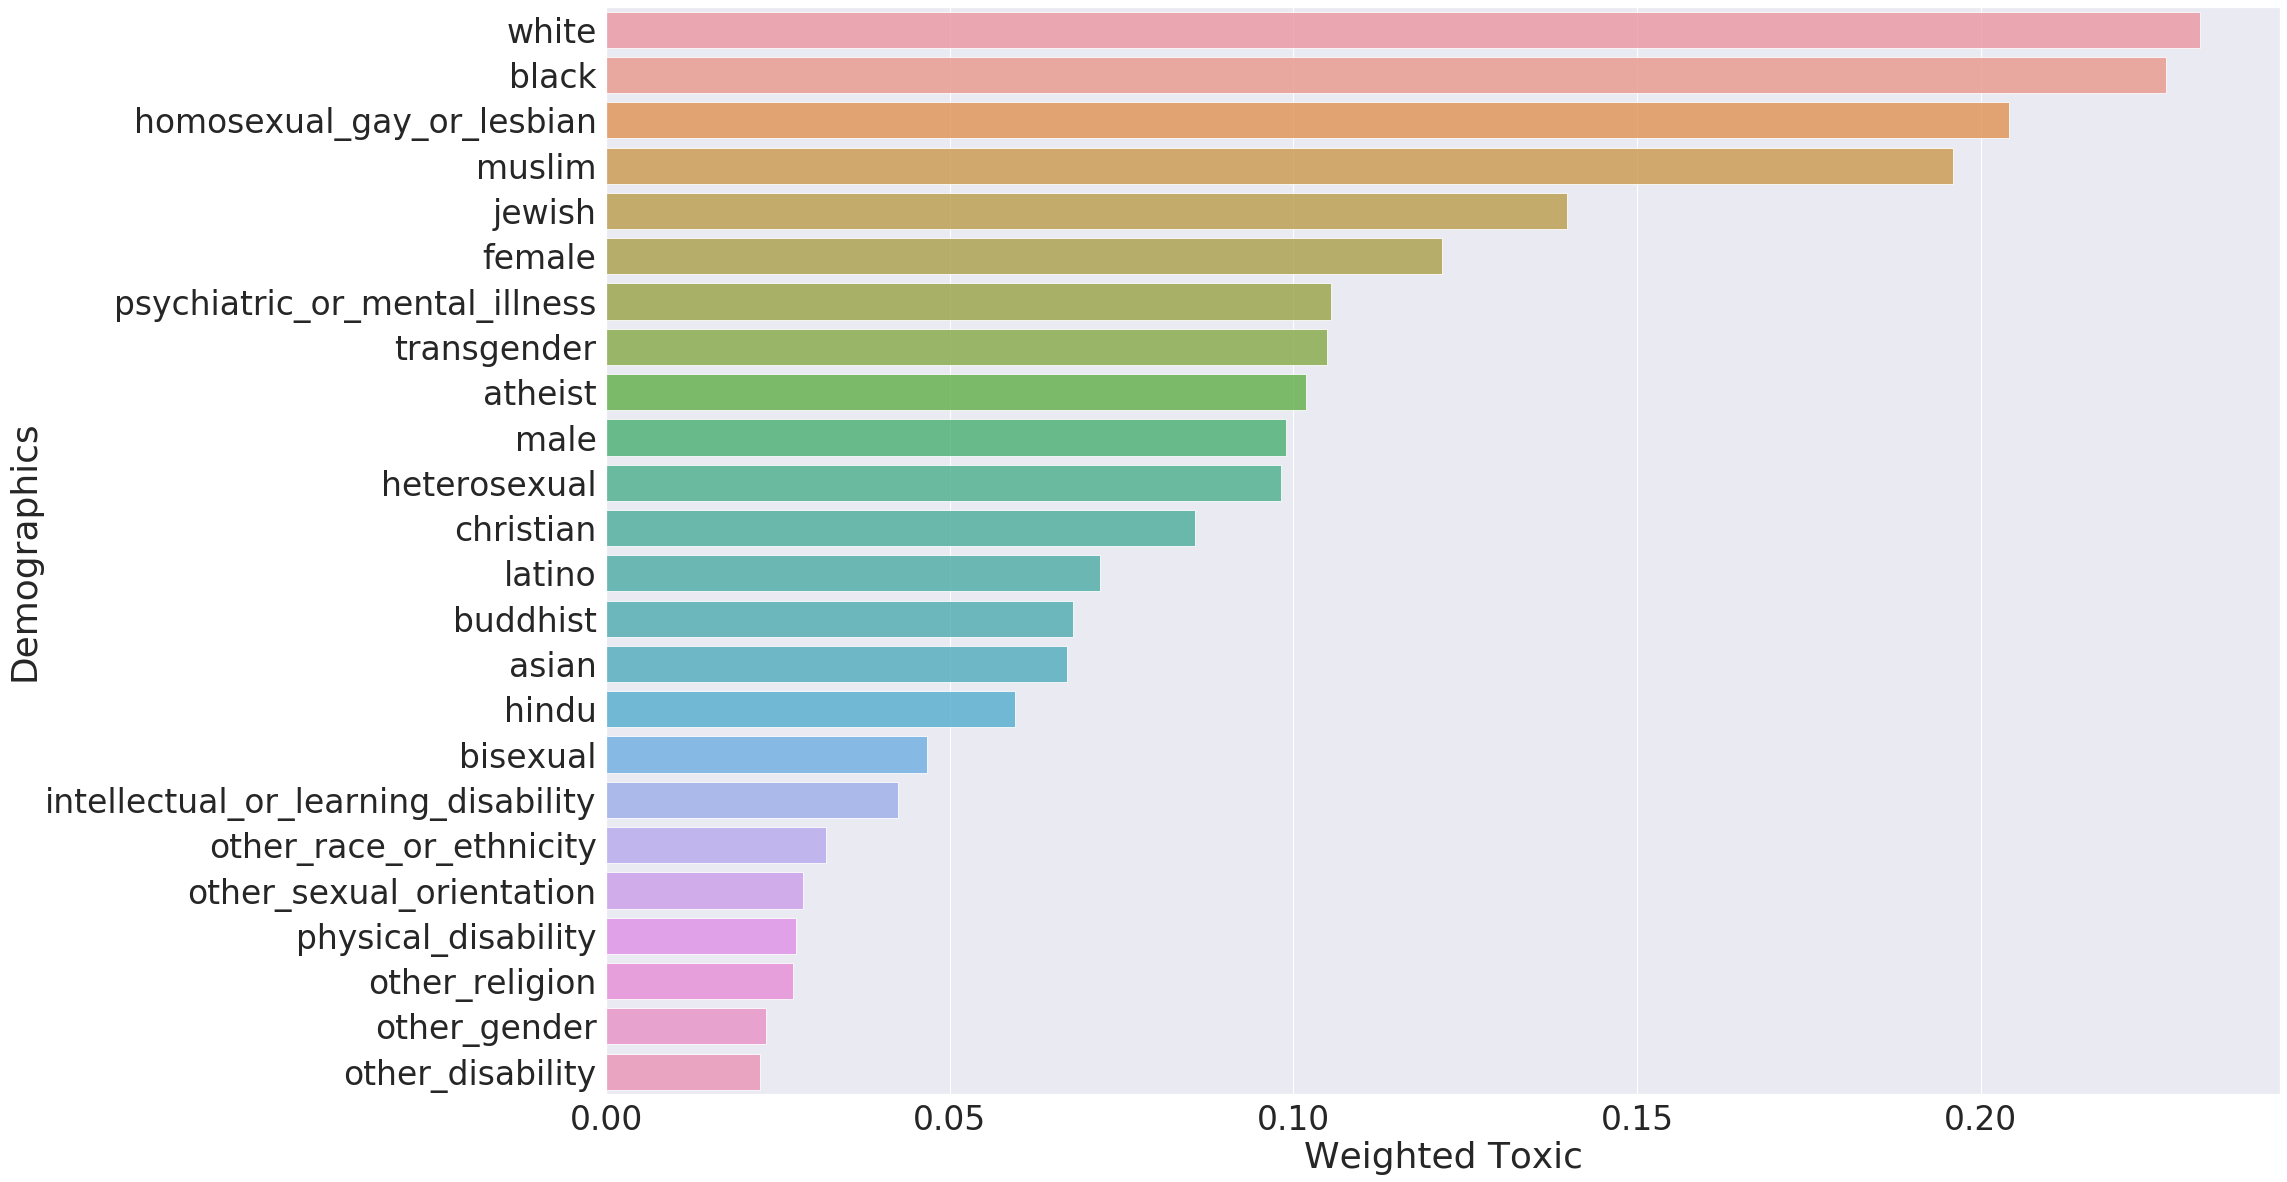

In [12]:
demographics = train.loc[:, ['target']+list(train)[slice(8,32)]].dropna()
weighted_toxic = demographics.iloc[:, 1:].multiply(demographics.iloc[:, 0], axis="index").sum()/demographics.iloc[:, 1:][demographics.iloc[:, 1:]>0].count()
weighted_toxic = weighted_toxic.sort_values(ascending=False)
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values, y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Demographics')
plt.xlabel('Weighted Toxic')
plt.show()

Meanwhile, we can check the correlations between identities and the comment labels.

In [14]:
identities = tuple(train.iloc[:, 8:32])
rows = [{c:train[f].corr(train[c]) for c in columns} for f in identities]
poptoxicity_correlations = pd.DataFrame(rows, index=identities)

In [21]:
poptoxicity_correlations

,target,severe_toxicity,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
asian,0.007205,0.005371,-0.004047,0.041203,-0.000664,-0.002817,-0.000409,0.010691,0.001051,-0.003144,0.007868,-0.013710,0.021327,0.001216
atheist,0.010625,0.005047,-0.000122,0.031167,0.005152,0.000781,-0.002847,-0.002600,0.000051,-0.002436,0.001031,-0.004954,0.023635,-0.000433
bisexual,0.021057,0.009279,0.005323,0.047476,0.006283,-0.001796,-0.003230,-0.000367,-0.002987,0.009078,-0.004104,0.024218,0.015360,-0.000380
black,0.167224,0.094418,0.026267,0.314422,0.098186,0.048630,-0.020852,0.001483,0.004480,-0.012769,-0.000631,-0.006407,0.018075,0.035702
buddhist,0.004613,0.004260,-0.001751,0.024143,-0.002909,0.002542,-0.002802,-0.001222,-0.001348,-0.000621,-0.001719,-0.004397,0.010600,-0.002119
christian,-0.006776,-0.000874,-0.025650,0.093885,-0.030669,-0.014324,-0.008460,-0.013146,-0.015212,0.021608,-0.020644,0.008710,0.018038,-0.015846
female,0.062904,0.032653,0.036250,0.052299,0.037995,0.023384,-0.012743,0.008052,0.005052,0.036137,0.008464,0.153735,0.009830,0.007588
heterosexual,0.038193,0.018239,0.008396,0.073282,0.012613,-0.003600,-0.002225,-0.001381,-0.001339,0.006148,-0.002821,0.066624,0.010674,0.003018
hindu,0.003607,0.003839,-0.002221,0.022695,-0.001895,0.001549,-0.002369,-0.000161,-0.001025,0.002924,0.002689,-0.005251,0.014825,-0.001248
homosexual_gay_or_lesbian,0.131110,0.064122,0.026097,0.249880,0.061920,0.016785,-0.003616,-0.001935,0.003452,0.012015,-0.002378,0.099424,0.020577,0.019139


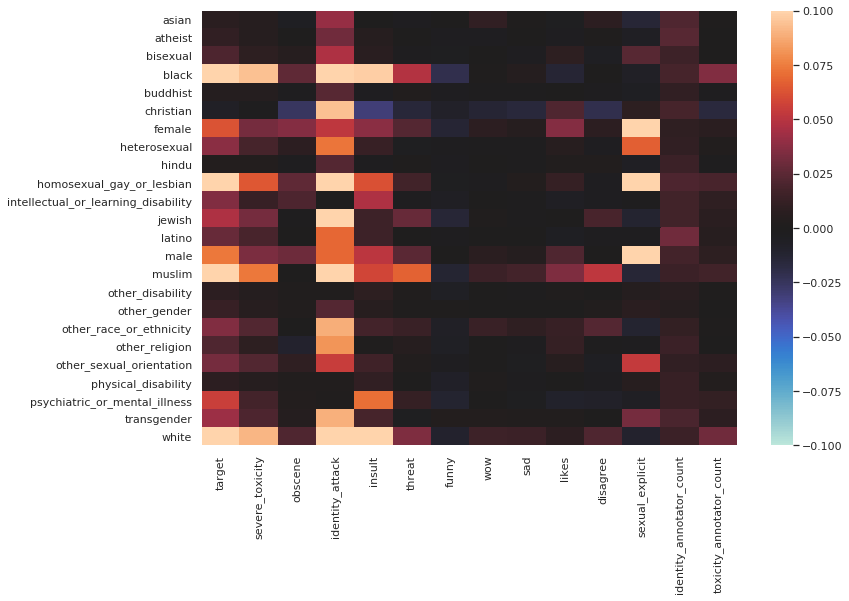

In [16]:
plt.figure(figsize=(12, 8))
sns.set(font_scale=1)
ax = sns.heatmap(poptoxicity_correlations, vmin=-0.1, vmax=0.1, center=0.0)

Moreover, we can do something fun, digging into the text with WordCloud. Let's check the Words frequented in Toxic Comments.

In [17]:
def toxicwordcloud(subset=train[train.target>0.7], title = "Words Frequented"):
    stopword=set(STOPWORDS)
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
    wc.generate(" ".join(text))
    plt.figure(figsize=(8,8))
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

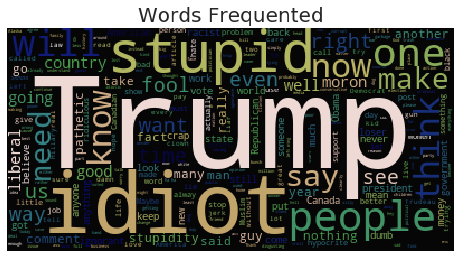

In [18]:
toxicwordcloud()

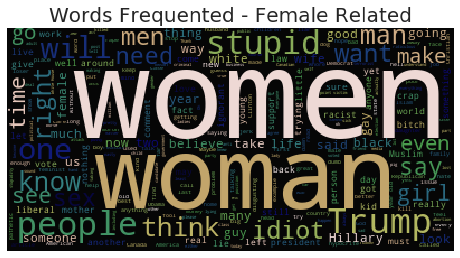

In [22]:
toxicwordcloud(subset = train[(train['female'] >0)&(train['target']>0.8)],title = "Words Frequented - Female Related")

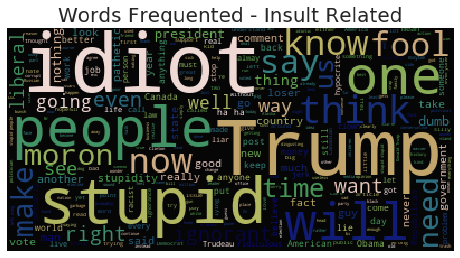

In [23]:
toxicwordcloud(subset = train[(train['insult'] >0.8)&(train['target']>0.8)],title = "Words Frequented - Insult Related")

## Kaggle References


- @Andrew Lukyanenko, https://www.kaggle.com/artgor/toxicity-eda-model-interpretation-and-more
- @Eike Dehling: https://www.kaggle.com/eikedehling/feature-engineering
- @Jagan: https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
- @Theo Viel: https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing
- @Aditya Soni: https://www.kaggle.com/adityaecdrid/public-version-text-cleaning-vocab-65
- @Guillaume Martin: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
- @Shujian Liu: https://www.kaggle.com/shujian/test-the-difficulty-of-this-classification-tasks




# Conclusion

In this kernel, we've found out that the categories we need to predict are overlapping each over. In the basic exploration of words contained in the comments, we can say that the vocabulary is quite similar across all categories except for the 'none' one. While this might be enough to detect unwanted comments, it is clearly not enough to categorised them. 